# Dataset and model statistics

## Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dotenv

dotenv.load_dotenv()

True

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

In [33]:
import copy
from pprint import pprint
from typing import List
from itertools import chain
from collections import Counter, namedtuple, defaultdict
from pathlib import Path
import json

import pandas as pd
from nltk import PunktSentenceTokenizer
import numpy as np
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.model_selection import train_test_split

from info_loss import statistics
from info_loss.iaa import (
    char_span_to_token_span,
    char_spans_to_token_spans,
    exact_span_match,
    partial_span_match,
    sentence_level,
    Span,
    span_overlap,
)

## Load data

In [5]:
def load_data(path, include_ids=None):
    data = statistics.load_data(path)
    if include_ids:
        include_ids = set(include_ids)
        data = [doc for doc in data if doc["id"] in include_ids]
    return data

In [6]:
anns_karim = load_data("../data/raw/annotations/annotations-karim/")
anns_kathryn = load_data("../data/raw/annotations/annotations-kathryn/")
anns_keziah = load_data("../data/raw/annotations/annotations-keziah/")
ids_completed = set([d["id"] for d in chain(anns_karim, anns_keziah, anns_kathryn)])
anns_union = {}
for doc in chain(anns_karim, anns_kathryn, anns_keziah):
    if doc["id"] in anns_union:
        anns_union[doc["id"]]["edits"].extend(doc["edits"])
    else:
        anns_union[doc["id"]] = copy.deepcopy(doc)
anns_union = list(anns_union.values())

anns_gpt4_e2e = load_data(
    "../output/gpt-4-0613-one-shot/predictions.json", include_ids=ids_completed
)
anns_llama_e2e = load_data(
    "../output/llama2-70b-chat-one-shot/predictions.json", include_ids=ids_completed
)
anns_mistral_e2e = load_data(
    "../output/mistral-7b-instruct-one-shot/predictions.json", include_ids=ids_completed
)
anns_gpt4_nli = load_data(
    "../output/gpt-4-0613-nli/predictions.json", include_ids=ids_completed
)

In [7]:
df_docs = pd.read_json("../data/processed/documents.json")
df_docs = df_docs[df_docs["PMCID"].isin(ids_completed)]
df_docs = df_docs.reset_index(drop=True)
df_docs.head()

,title,abstract,sectioned,PMCID,simplification
0,Efficacy of lanreotide Autogel® administered e...,OBJECTIVE AND DESIGN.\nDepot somatostatin anal...,True,1618957,GOAL AND PLAN\nThe goal of this study was to s...
1,Buprenorphine versus dihydrocodeine for opiate...,BACKGROUND.\nMany drug users present to primar...,True,1774569,BACKGROUND:\nMany drug users go to their regul...
2,Advantages and disadvantages of an objective s...,BACKGROUND.\nIt is unclear if objective select...,True,1868720,BACKGROUND.\nThis study looks at if picking wo...
3,Neck pain in chronic whiplash syndrome treated...,OBJECTIVES.\nNeck pain in chronic whiplash syn...,True,1915612,OBJECTIVES\nMany people who have long-term nec...
4,"An Open Label, Randomised Trial of Artesunate+...",BACKGROUND.\nArtesunate+amodiaquine (AS+AQ) an...,True,2430614,BACKGROUND.\nThis study is about comparing thr...


## Annotation Duration

In [8]:
durations = pd.concat(
    [
        pd.DataFrame(anns_keziah)["_seconds_spent"],
        pd.DataFrame(anns_karim)["_seconds_spent"],
        pd.DataFrame(anns_kathryn)["_seconds_spent"],
    ]
)
n_total = len(durations)
print(f"Total completed: {n_total}")
durations = durations.dropna()
durations = durations / 60
duration_stats = durations.describe()
median_duration = duration_stats.loc["50%"]
print(f"w/ timing: {len(durations)}")
print()
print("Annotation duration in minutes:")
print(duration_stats.round(1))
print()
print(f"Estimated total: {median_duration * n_total / 60:.1f}h")

Total completed: 208
w/ timing: 87

Annotation duration in minutes:
count    87.0
mean     24.3
std      14.0
min       3.6
25%      13.8
50%      21.6
75%      31.2
max      79.8
Name: _seconds_spent, dtype: float64

Estimated total: 74.9h


## Inter-annotator Agreement (IAA)

- Exact match F1
- Partial match F1
- Sentence-level Krippendorff's Alpha

In [9]:
def edits_to_spans(doc_id, edits):
    anns = []
    for ann in edits:
        anns.append(
            Span(
                doc_id,
                ann["category"],
                ann["input_idx"][0][0],
                ann["input_idx"][0][1],
            )
        )
    return anns


agg = statistics.load_data_aggregated(
    annotators=[
        ("karim", "../data/raw/annotations/annotations-karim/"),
        ("kathryn", "../data/raw/annotations/annotations-kathryn/"),
        ("keziah", "../data/raw/annotations/annotations-keziah/"),
    ]
)
agg = list(agg.values())

texts = []
annotator_1 = []
annotator_2 = []
for doc in agg:
    texts.append(doc["source"])
    anns_1 = edits_to_spans(doc["id"], doc["annotations"][0]["edits"])
    anns_2 = edits_to_spans(doc["id"], doc["annotations"][1]["edits"])
    annotator_1.append(anns_1)
    annotator_2.append(anns_2)

annotator_1_tokens = [
    char_spans_to_token_spans(text, anns) for text, anns in zip(texts, annotator_1)
]
annotator_2_tokens = [
    char_spans_to_token_spans(text, anns) for text, anns in zip(texts, annotator_2)
]

In [10]:
iaa_exact = exact_span_match(annotator_1, annotator_2)
iaa_partial = partial_span_match(annotator_1_tokens, annotator_2_tokens, threshold=0.5)
iaa_sentence = sentence_level(texts, annotator_1, annotator_2)

print("Exact match")
pprint(iaa_exact)
print()

print("Partial match (t = 0.5)")
pprint(iaa_partial)
print()

print("Sentence-level Krippendorff's alpha")
pprint(iaa_sentence)

Exact match
{'labels': {'concept': {'f1': 0.1349527665317139,
                        'fn': 340,
                        'fp': 301,
                        'precision': 0.14245014245014245,
                        'recall': 0.1282051282051282,
                        'tp': 50},
            'omission': {'f1': 0.20077220077220076,
                         'fn': 96,
                         'fp': 111,
                         'precision': 0.1897810218978102,
                         'recall': 0.21311475409836064,
                         'tp': 26}},
 'macro_average': {'f1': 0.16786248365195733,
                   'precision': 0.16611558217397632,
                   'recall': 0.17065994115174443}}

Partial match (t = 0.5)
{'labels': {'concept': {'f1': 0.33738191632928477,
                        'fn': 265,
                        'fp': 226,
                        'precision': 0.3561253561253561,
                        'recall': 0.32051282051282054,
                        'tp': 125},
   

In [11]:
header = ["Granularity (measure)", "Del.", "Oversimp.", "Aggregate"]
rows = [
    (
        "Span, exact (F1)",
        iaa_exact["labels"]["omission"]["f1"],
        iaa_exact["labels"]["concept"]["f1"],
        iaa_exact["macro_average"]["f1"],
    ),
    (
        "Span, partial (F1)",
        iaa_partial["labels"]["omission"]["f1"],
        iaa_partial["labels"]["concept"]["f1"],
        iaa_partial["macro_average"]["f1"],
    ),
    ("Sentence ($\\alpha$)", np.nan, np.nan, iaa_sentence["binary"]),
]

df_iaa = pd.DataFrame(data=rows, columns=header)
df_iaa = df_iaa.round(2)
display(df_iaa)

tex = df_iaa.to_latex(
    index=False,
    position="t",
    caption="TODO",
    label="tab:iaa-annotation",
    na_rep="n/a",
    float_format=lambda x: "{:0.2f}".format(x) if pd.notna(x) else x,
)
for h in header:
    tex = tex.replace(h, "\\textbf{" + h + "}")
print(tex)

,Granularity (measure),Del.,Oversimp.,Aggregate
0,"Span, exact (F1)",0.20,0.13,0.17
1,"Span, partial (F1)",0.34,0.34,0.34
2,Sentence ($\alpha$),NaN,NaN,0.50


\begin{table}[t]
\caption{TODO}
\label{tab:iaa-annotation}
\begin{tabular}{lrrr}
\toprule
\textbf{Granularity (measure)} & \textbf{Del.} & \textbf{Oversimp.} & \textbf{Aggregate} \\
\midrule
Span, exact (F1) & 0.20 & 0.13 & 0.17 \\
Span, partial (F1) & 0.34 & 0.34 & 0.34 \\
Sentence ($\alpha$) & n/a & n/a & 0.50 \\
\bottomrule
\end{tabular}
\end{table}



## QA Similarity

1. Get all QA pairs
2. Classify as `{complete, partial, no overlap}`
3. Calculate question similarity (S-BERT)
4. Plot

In [12]:
SIMILARITY_MODEL = SentenceTransformer("all-MiniLM-L6-v2")


def compute_similarity(model, sentences_a, sentences_b):
    embeddings_a = model.encode(sentences_a, convert_to_tensor=True)
    embeddings_b = model.encode(sentences_b, convert_to_tensor=True)
    similarity_scores = 1 - paired_cosine_distances(embeddings_a, embeddings_b)
    return similarity_scores

In [13]:
all_pairs = []
for doc in agg:
    ann_1 = doc["annotations"][0]["edits"]
    ann_2 = doc["annotations"][1]["edits"]

    for a in ann_1:
        a_start, a_end = a["input_idx"][0][0], a["input_idx"][0][1]
        a_start_tok, a_end_tok = char_span_to_token_span(doc["source"], a_start, a_end)
        for b in ann_2:
            b_start, b_end = b["input_idx"][0][0], b["input_idx"][0][1]
            b_start_tok, b_end_tok = char_span_to_token_span(
                doc["source"], b_start, b_end
            )

            a_range = set(range(a_start_tok, a_end_tok))
            b_range = set(range(b_start_tok, b_end_tok))
            iou = len(a_range & b_range) / len(a_range | b_range)

            if (a_start, a_end) == (b_start, b_end):
                label = "Exact"
            elif iou >= 0.5:
                label = "Partial"
            else:
                label = "No Overlap"

            all_pairs.append(
                (
                    a["annotation"]["question"],
                    a["annotation"]["answer"],
                    b["annotation"]["question"],
                    b["annotation"]["answer"],
                    label,
                )
            )

all_pairs = pd.DataFrame(
    all_pairs, columns=["question_a", "answer_a", "question_b", "answer_b", "label"]
)
batchsize = 100
scores = []
for i in tqdm(range(0, len(all_pairs), batchsize)):
    scores.extend(
        compute_similarity(
            SIMILARITY_MODEL,
            all_pairs.iloc[i : i + batchsize]["question_a"].tolist(),
            all_pairs.iloc[i : i + batchsize]["question_b"].tolist(),
        )
    )

all_pairs["question_sim"] = scores
print(all_pairs["label"].value_counts())

  0%|          | 0/27 [00:00<?, ?it/s]

label
No Overlap    2443
Partial        111
Exact           84
Name: count, dtype: int64


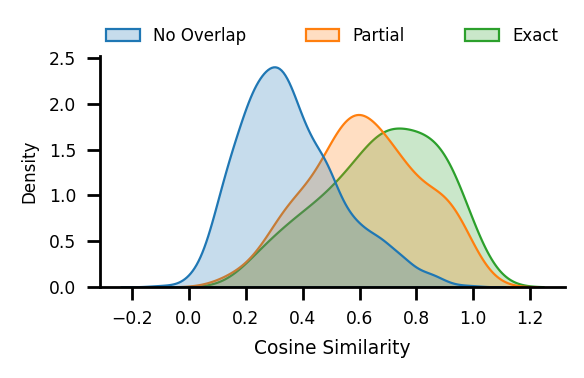

In [14]:
with sns.plotting_context("paper", font_scale=0.7):
    fig, ax = plt.subplots(1, 1, figsize=(3, 1.5))
    sns.kdeplot(
        all_pairs, x="question_sim", hue="label", common_norm=False, fill=True, ax=ax
    )
    sns.move_legend(
        ax,
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        loc="lower left",
        mode="expand",
        borderaxespad=0,
        ncol=3,
        title="",
        frameon=False,
        fontsize=6,
    )
    plt.ylabel("Density", size=6)
    plt.xlabel("Cosine Similarity")
    sns.despine()
    plt.show()

    with PdfPages("figures/question-similarity.pdf") as pdf:
        pdf.savefig(fig, bbox_inches="tight")

## Summary statistics of gold data

In [15]:
df_corpus_stats = statistics.corpus_statistics(anns_union).to_frame()
df_corpus_stats.loc["compression"] = df_corpus_stats.loc["compression"].multiply(100)
df_corpus_stats.loc["novelty_uni"] = df_corpus_stats.loc["novelty_uni"].multiply(100)
df_corpus_stats.loc["novelty_bi"] = df_corpus_stats.loc["novelty_bi"].multiply(100)
df_corpus_stats.round(1)

,0
src_len,312.1
tgt_len,270.7
compression,11.2
novelty_uni,55.7
novelty_bi,86.7
src_fre,44.1
tgt_fre,59.7
num_docs,104.0


In [16]:
rename = {
    "num_documents": "Docs.",
    "num_question_answer_pairs": "QA",
    "num_omission": "% Del",
    "num_concept": "% Over",
    "avg_questions_per_document": "QA/doc",
    "avg_question_length": "$|Q|$",
    "avg_answer_length": "$|A|$",
    "avg_input_span_length": "$|s_c|$",
    "avg_output_span_length": "$|s_s|$",
}

In [17]:
df_summary = statistics.summary_statistics(anns_union).T
df_summary["num_question_answer_pairs"] = df_summary[
    "num_question_answer_pairs"
].astype(int)
df_summary["num_documents"] = df_summary["num_documents"].astype(int)
df_summary["num_omission"] = df_summary["num_omission"].multiply(100)
df_summary["num_concept"] = df_summary["num_concept"].multiply(100)
df_summary = df_summary.rename(rename, axis=1)
df_summary = df_summary.round(1)
df_summary

,Docs.,QA,% Over,% Del,QA/doc,$|Q|$,$|A|$,$|s_c|$,$|s_s|$
all,104,1000,74.1,25.9,9.6,11.4,30.3,14.4,8.5
concept,104,741,NaN,NaN,7.1,11.1,30.5,14.7,8.5
omission,81,259,NaN,NaN,3.2,12.5,30.0,13.6,NaN


In [18]:
df_secs = statistics.section_distribution(anns_union)
df_secs = df_secs.multiply(100).round(1)
df_secs

,Background,Methods,Results,Conclusion,n/a (Multiple),n/a (Unsectioned)
all,16.1,41.7,19.9,3.5,2.1,16.7
concept,15.1,44.4,20.9,3.5,2.2,13.9
omission,18.9,34.0,17.0,3.5,1.9,24.7


In [19]:
has_sections = sum(len(doc["sections"]) == 1 for doc in anns_union)

print(f"Total docs: {len(anns_union)}")
print(f"w/o Sections: {has_sections} ({has_sections/len(anns_union)*100:.1f}%)")

Total docs: 104
w/o Sections: 20 (19.2%)


## Compare annotators/models

Summary statistics

In [20]:
df_stats = pd.DataFrame(
    [
        statistics.summary_statistics(anns_karim)["all"].rename("Annotator 1"),
        statistics.summary_statistics(anns_kathryn)["all"].rename("Annotator 2"),
        statistics.summary_statistics(anns_keziah)["all"].rename("Annotator 3"),
        statistics.summary_statistics(anns_union)["all"].rename("All (micro avg.)"),
        statistics.summary_statistics(anns_mistral_e2e)["all"].rename("Mistral-7B"),
        statistics.summary_statistics(anns_llama_e2e)["all"].rename("Llama2-70B"),
        statistics.summary_statistics(anns_gpt4_e2e)["all"].rename("GPT-4"),
        statistics.summary_statistics(anns_gpt4_nli)["all"].rename("NLI (GPT-4)"),
    ]
)
df_stats["num_concept"] = df_stats["num_concept"].fillna(0).multiply(100)
df_stats["num_omission"] = df_stats["num_omission"].fillna(0).multiply(100)
df_stats = df_stats.round(1)
df_stats["num_question_answer_pairs"] = df_stats["num_question_answer_pairs"].astype(
    int
)
df_stats["num_documents"] = df_stats["num_documents"].astype(int)
df_stats = df_stats.rename(rename, axis=1)
display(df_stats)

df_stats = df_stats.style.format(precision=1, na_rep="--")
tex = df_stats.to_latex(
    position="t",
    hrules=True,
    position_float="centering",
)
tex = tex.replace(
    r"\begin{table}[t]", "\\begin{table*}[t]\n\\small\n\\setlength{\\tabcolsep}{5pt}"
)
tex = tex.replace(r"\end{table}", r"\end{table*}")
# for c in df_stats.columns:
#     tex = tex.replace(c, "\\textbf{" + c + "}")
tex = tex.replace("%", r"\%")
print(tex)

,Docs.,QA,% Over,% Del,QA/doc,$|Q|$,$|A|$,$|s_c|$,$|s_s|$
Annotator 1,48,192,90.1,9.9,4.1,10.8,23.8,12.2,7.6
Annotator 2,75,425,71.8,28.2,5.7,12.2,33.4,15.5,9.0
Annotator 3,85,383,68.7,31.3,4.7,10.9,30.2,14.4,8.6
All (micro avg.),104,1000,74.1,25.9,9.6,11.4,30.3,14.4,8.5
Mistral-7B,104,507,45.2,54.8,4.9,11.6,26.2,22.3,18.1
Llama2-70B,104,681,38.2,61.8,6.7,12.9,30.6,20.4,15.7
GPT-4,104,477,48.4,51.6,4.6,14.4,33.7,25.4,20.6
NLI (GPT-4),104,1699,0.0,100.0,16.5,14.5,24.6,34.7,NaN


\begin{table*}[t]
\small
\setlength{\tabcolsep}{5pt}
\centering
\begin{tabular}{lrrrrrrrrr}
\toprule
 & Docs. & QA & \% Over & \% Del & QA/doc & $|Q|$ & $|A|$ & $|s_c|$ & $|s_s|$ \\
\midrule
Annotator 1 & 48 & 192 & 90.1 & 9.9 & 4.1 & 10.8 & 23.8 & 12.2 & 7.6 \\
Annotator 2 & 75 & 425 & 71.8 & 28.2 & 5.7 & 12.2 & 33.4 & 15.5 & 9.0 \\
Annotator 3 & 85 & 383 & 68.7 & 31.3 & 4.7 & 10.9 & 30.2 & 14.4 & 8.6 \\
All (micro avg.) & 104 & 1000 & 74.1 & 25.9 & 9.6 & 11.4 & 30.3 & 14.4 & 8.5 \\
Mistral-7B & 104 & 507 & 45.2 & 54.8 & 4.9 & 11.6 & 26.2 & 22.3 & 18.1 \\
Llama2-70B & 104 & 681 & 38.2 & 61.8 & 6.7 & 12.9 & 30.6 & 20.4 & 15.7 \\
GPT-4 & 104 & 477 & 48.4 & 51.6 & 4.6 & 14.4 & 33.7 & 25.4 & 20.6 \\
NLI (GPT-4) & 104 & 1699 & 0.0 & 100.0 & 16.5 & 14.5 & 24.6 & 34.7 & -- \\
\bottomrule
\end{tabular}
\end{table*}



Section distribution

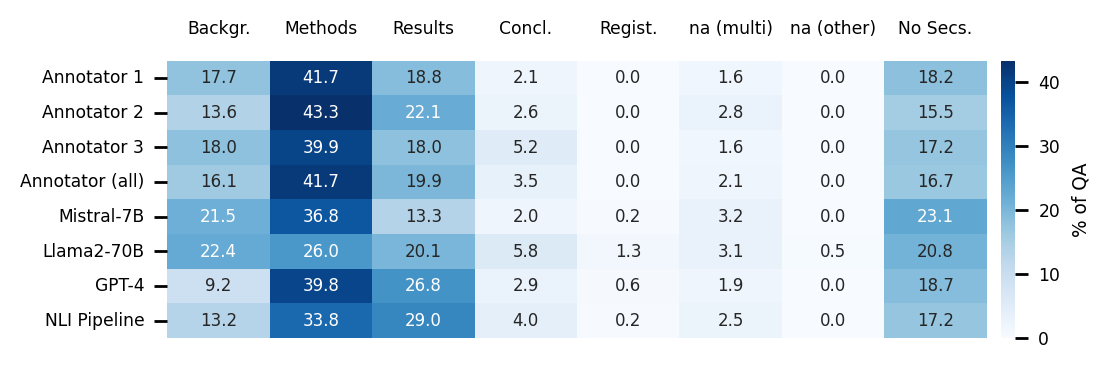

In [21]:
df_stats = pd.DataFrame(
    [
        statistics.section_distribution(anns_karim).loc["all"].rename("Annotator 1"),
        statistics.section_distribution(anns_kathryn).loc["all"].rename("Annotator 2"),
        statistics.section_distribution(anns_keziah).loc["all"].rename("Annotator 3"),
        statistics.section_distribution(anns_union)
        .loc["all"]
        .rename("Annotator (all)"),
        statistics.section_distribution(anns_mistral_e2e)
        .loc["all"]
        .rename("Mistral-7B"),
        statistics.section_distribution(anns_llama_e2e).loc["all"].rename("Llama2-70B"),
        statistics.section_distribution(anns_gpt4_e2e).loc["all"].rename("GPT-4"),
        statistics.section_distribution(anns_gpt4_nli)
        .loc["all"]
        .rename("NLI Pipeline"),
    ],
)
rename_cols = {
    "Background": "Backgr.",
    "Methods": "Methods",
    "Results": "Results",
    "Conclusion": "Concl.",
    "Registration": "Regist.",
    "n/a (Multiple)": "na (multi)",
    "n/a (Other)": "na (other)",
    "n/a (Unsectioned)": "No Secs.",
}

df_stats = df_stats.multiply(100)
df_stats = df_stats[rename_cols.keys()]
df_stats = df_stats.rename(rename_cols, axis=1)

with sns.plotting_context("paper", font_scale=0.7):
    fig, ax = plt.subplots(figsize=(6.33, 1.8))  # Sample figsize in inches
    sns.heatmap(
        df_stats.fillna(0),
        annot=True,
        cmap="Blues",
        ax=ax,
        annot_kws={"fontsize": 6},
        fmt=".1f",
        cbar_kws={"label": "% of QA", "pad": 0.015},
    )
    cbar = ax.collections[0].colorbar
    # cbar.ax.tick_params(labelsize=20)
    ax.tick_params(
        axis="both",
        which="major",
        labelbottom=False,
        bottom=False,
        top=False,
        labeltop=True,
    )

    with PdfPages("figures/info-loss-distribution-section.pdf") as pdf:
        pdf.savefig(fig, bbox_inches="tight")

    plt.show()

## Visualize Location of Info Loss

In [22]:
def project_annotations(text: str, edits):
    sents = list(PunktSentenceTokenizer().span_tokenize(text))

    sents_labels = []
    for sent_start, sent_end in sents:
        count = 0
        for edit in edits:
            if len(edit.get("prediction_errors", [])) > 0:
                continue

            ann_start = edit["input_idx"][0][0]
            ann_end = edit["input_idx"][0][1]
            if span_overlap(sent_start, sent_end, ann_start, ann_end):
                count += 1
        sents_labels.append(count)

    return sents_labels

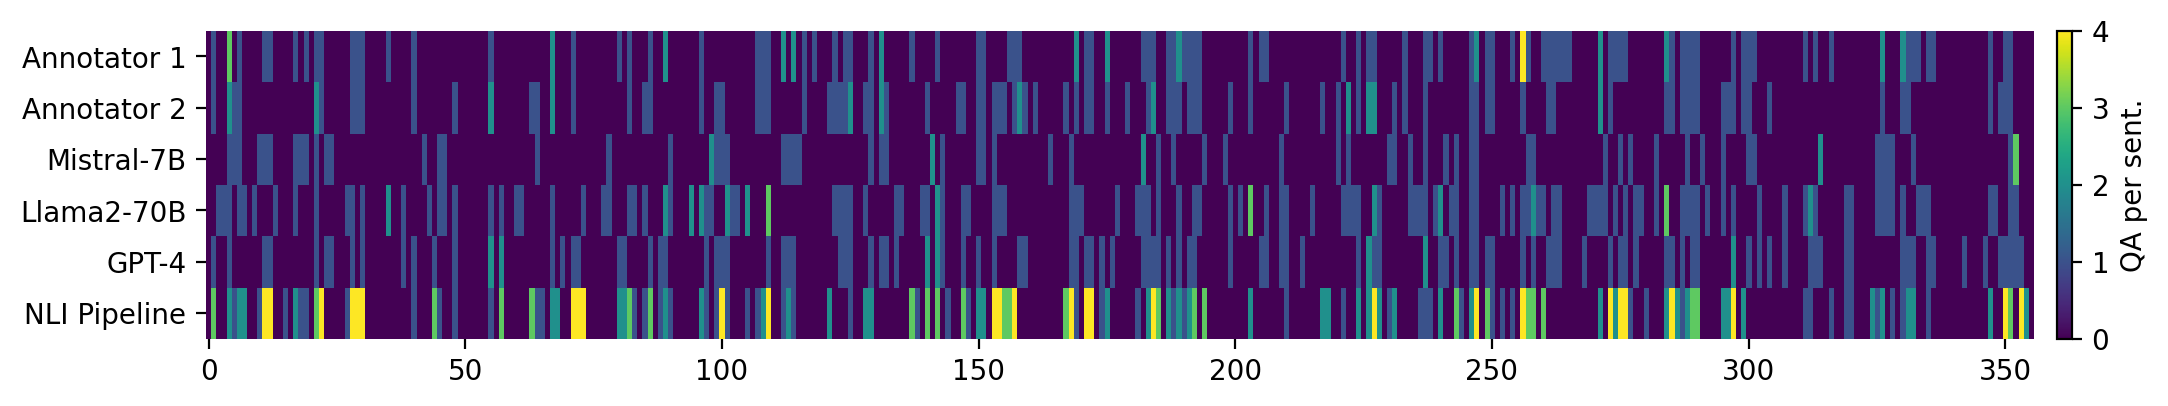

In [23]:
llama_projected = []
for doc in sorted(anns_llama_e2e, key=lambda doc: doc["id"]):
    llama_projected.append(project_annotations(doc["source"], doc["edits"]))

gpt4_projected = []
for doc in sorted(anns_gpt4_e2e, key=lambda doc: doc["id"]):
    gpt4_projected.append(project_annotations(doc["source"], doc["edits"]))

mistral_projected = []
for doc in sorted(anns_mistral_e2e, key=lambda doc: doc["id"]):
    mistral_projected.append(project_annotations(doc["source"], doc["edits"]))

nli_projected = []
for doc in sorted(anns_gpt4_nli, key=lambda doc: doc["id"]):
    nli_projected.append(project_annotations(doc["source"], doc["edits"]))

human_1 = []
human_2 = []
for doc in sorted(agg, key=lambda doc: doc["id"]):
    human_1.append(project_annotations(doc["source"], doc["annotations"][0]["edits"]))
    human_2.append(project_annotations(doc["source"], doc["annotations"][1]["edits"]))


def flatten(l):
    return [e for sub in l for e in sub]


N = 25
a = [
    flatten(human_1[:N]),
    flatten(human_2[:N]),
    flatten(mistral_projected[:N]),
    flatten(llama_projected[:N]),
    flatten(gpt4_projected[:N]),
    flatten(nli_projected[:N]),
]
fig, ax = plt.subplots(figsize=(15, 2))
im = ax.imshow(a, vmin=0, vmax=4)
ax.set_aspect(aspect=10)
ax.set_yticks(
    range(len(a)),
    ["Annotator 1", "Annotator 2", "Mistral-7B", "Llama2-70B", "GPT-4", "NLI Pipeline"],
)
# plt.title('Distribution of Info Loss across the sentences of 25 documents.')
# plt.xlabel('Sentence ID')
cbar = fig.colorbar(im, pad=0.01, label="QA per sent.")

sns.despine(bottom=True, left=True)
with PdfPages("figures/info-loss-distribution-sentence.pdf") as pdf:
    pdf.savefig(fig, bbox_inches="tight", dpi=300)

## Count generation errors

In [24]:
def count_errors(docs, model_name):
    df_edits = pd.DataFrame(edit for doc in docs for edit in doc["edits"])
    if not "prediction_errors" in df_edits:
        df_edits["prediction_errors"] = ""
    df_edits["prediction_errors_str"] = df_edits["prediction_errors"].apply(
        lambda x: " ".join(sorted(x)) if len(x) > 0 else "valid"
    )
    error_counts = df_edits.groupby(["category"])["prediction_errors_str"].apply(
        lambda x: pd.Series.value_counts(x, normalize=True)
    )
    error_counts.name = model_name
    return error_counts.to_frame().reset_index(names=["category", "error"])

In [25]:
from collections import Counter

In [26]:
total_counts = pd.DataFrame(
    [
        Counter(edit["category"] for doc in anns_mistral_e2e for edit in doc["edits"]),
        Counter(edit["category"] for doc in anns_llama_e2e for edit in doc["edits"]),
        Counter(edit["category"] for doc in anns_gpt4_e2e for edit in doc["edits"]),
        Counter(edit["category"] for doc in anns_gpt4_nli for edit in doc["edits"]),
    ],
    index=["mistral-e2e", "llama-e2e", "gpt4-e2e", "gpt4-nli"],
)

print("Total generated QAs")
total_counts.T.fillna(0).astype(int)

Total generated QAs


,mistral-e2e,llama-e2e,gpt4-e2e,gpt4-nli
omission,278,421,246,1699
concept,229,260,231,0


In [27]:
def docs_to_edits_frame(docs, model_name):
    df = pd.DataFrame(edit for doc in docs for edit in doc["edits"])
    df["model"] = model_name
    if not "prediction_errors" in df:
        df["prediction_errors"] = ""
    df["prediction_errors_str"] = df["prediction_errors"].apply(
        lambda x: " ".join(sorted(x)) if len(x) > 0 else "valid"
    )
    df = df.drop("id", axis=1)
    return df


df_all_edits = pd.concat(
    [
        docs_to_edits_frame(anns_mistral_e2e, "mistral-e2e"),
        docs_to_edits_frame(anns_llama_e2e, "llama-e2e"),
        docs_to_edits_frame(anns_gpt4_e2e, "gpt4-e2e"),
        docs_to_edits_frame(anns_gpt4_nli, "gpt4-nli"),
    ]
)
display(df_all_edits.head())


grouped = df_all_edits.groupby(["model", "category"])
value_counts = grouped["prediction_errors_str"].value_counts(normalize=True)
value_counts = value_counts.to_frame().unstack(level=0)
value_counts.columns = value_counts.columns.droplevel(0)
value_counts.columns.name = ""
value_counts = value_counts.multiply(100).fillna(0)

totals = grouped.size().unstack(level=0).fillna(0).astype(int)
totals["prediction_errors_str"] = "total"
totals = totals.set_index("prediction_errors_str", append=True)
totals.columns.name = ""

rename = {
    "omission": "Deletion",
    "concept": "Oversimplification",
    "mistral-e2e": "Mistral-7B",
    "llama-e2e": "Llama2-70B",
    "gpt4-e2e": "GPT-4",
    "gpt4-nli": "NLI Pipeline",
    "valid": "Valid",
    "invalid_input_localization": "Invalid $E$",
    "spurious_output_localization": "Spurious $R$",
    "missing_output_localization": "Missing $R$",
    "invalid_output_localization": "Invalid $R$",
    "invalid_input_localization missing_output_localization": "Invalid $E$ + Missing $R$",
    "invalid_input_localization invalid_output_localization": "Invalid $E$ + Invalid $R$",
    "total": "$N$",
    "prediction_errors_str": "Error",
}


df = pd.concat([value_counts, totals])
df = df.sort_values(["category", "mistral-e2e"], ascending=[False, False])
df = df[["mistral-e2e", "llama-e2e", "gpt4-e2e", "gpt4-nli"]]
df = df.rename(rename, axis=1)
df = df.rename(rename, axis=0)
df = df.reset_index()

display(df)

tex = (
    df.style.format(precision=1)
    .hide(axis=0)
    .to_latex(
        position="t",
        hrules=True,
        position_float="centering",
    )
)
print(tex)

,category,annotation,prediction_errors,input_idx,output_idx,model,prediction_errors_str
0,omission,{'question': 'Who were the participants in the...,[],"[[404, 581]]",NaN,mistral-e2e,valid
1,omission,{'question': 'How many shots of lanreotide Aut...,[],"[[582, 655]]",NaN,mistral-e2e,valid
2,omission,{'question': 'When were the injections of lanr...,[],"[[656, 814]]",NaN,mistral-e2e,valid
3,concept,{'question': 'What was the specific measure us...,[],"[[990, 1075]]","[[965, 1057]]",mistral-e2e,valid
4,concept,{'question': 'Was the difference in GH levels ...,[],"[[1132, 1265]]","[[1059, 1158]]",mistral-e2e,valid


,category,prediction_errors_str,Mistral-7B,Llama2-70B,GPT-4,NLI Pipeline
0,Deletion,$N$,278.000000,421.000000,246.0,1699.0
1,Deletion,Valid,61.870504,87.173397,100.0,100.0
2,Deletion,Spurious $R$,38.129496,0.950119,0.0,0.0
3,Deletion,Invalid $E$,0.000000,11.876485,0.0,0.0
4,Oversimplification,$N$,229.000000,260.000000,231.0,0.0
5,Oversimplification,Valid,67.248908,78.846154,100.0,0.0
6,Oversimplification,Invalid $R$,28.820961,5.769231,0.0,0.0
7,Oversimplification,Missing $R$,2.183406,6.153846,0.0,0.0
8,Oversimplification,Invalid $E$,1.746725,2.307692,0.0,0.0
9,Oversimplification,Invalid $E$ + Invalid $R$,0.000000,5.769231,0.0,0.0


\begin{table}[t]
\centering
\begin{tabular}{llrrrr}
\toprule
category & prediction_errors_str & Mistral-7B & Llama2-70B & GPT-4 & NLI Pipeline \\
\midrule
Deletion & $N$ & 278.0 & 421.0 & 246.0 & 1699.0 \\
Deletion & Valid & 61.9 & 87.2 & 100.0 & 100.0 \\
Deletion & Spurious $R$ & 38.1 & 1.0 & 0.0 & 0.0 \\
Deletion & Invalid $E$ & 0.0 & 11.9 & 0.0 & 0.0 \\
Oversimplification & $N$ & 229.0 & 260.0 & 231.0 & 0.0 \\
Oversimplification & Valid & 67.2 & 78.8 & 100.0 & 0.0 \\
Oversimplification & Invalid $R$ & 28.8 & 5.8 & 0.0 & 0.0 \\
Oversimplification & Missing $R$ & 2.2 & 6.2 & 0.0 & 0.0 \\
Oversimplification & Invalid $E$ & 1.7 & 2.3 & 0.0 & 0.0 \\
Oversimplification & Invalid $E$ + Invalid $R$ & 0.0 & 5.8 & 0.0 & 0.0 \\
Oversimplification & Invalid $E$ + Missing $R$ & 0.0 & 1.2 & 0.0 & 0.0 \\
\bottomrule
\end{tabular}
\end{table}



## Question types

In [28]:
df_union = pd.concat(
    [
        pd.read_json("../output/question-classification/questions-karim.json").assign(
            annotator="Anno 1"
        ),
        pd.read_json("../output/question-classification/questions-kathryn.json").assign(
            annotator="Anno 2"
        ),
        pd.read_json("../output/question-classification/questions-keziah.json").assign(
            annotator="Anno 3"
        ),
        pd.read_json("../output/gpt-4-0613-one-shot/questions.json").assign(
            annotator="GPT-4 (E2E)"
        ),
        pd.read_json("../output/llama2-70b-chat-one-shot/questions.json").assign(
            annotator="LLaMa-2 70B (E2E)"
        ),
        pd.read_json("../output/mistral-7b-instruct-one-shot/questions.json").assign(
            annotator="Mistral 7B (E2E)"
        ),
        pd.read_json("../output/gpt-4-0613-nli/questions.json").assign(
            annotator="GPT-4 (NLI)"
        ),
    ]
)
df_union = df_union[df_union["doc_id"].isin(ids_completed)]  # only keep completed docs

mask = df_union["annotator"].isin(["Anno 1", "Anno 2", "Anno 3"])
df_manual = df_union[mask]

df_union.head()

,doc_id,edit_id,question,category,label,annotator
0,1774569,1,Where are the tested drugs hoping to be used t...,omission,concept,Anno 1
1,1774569,1,Which illegal drugs are being addressed by the...,concept,concept,Anno 1
2,1774569,2,What other parameters was the study done under?,concept,concept,Anno 1
3,1774569,3,How were these drugs administered?,concept,procedural,Anno 1
4,1774569,4,How much more likely were the buprenorphine gr...,concept,extent,Anno 1


Human stats + examples

In [29]:
labels = [
    "cause",
    "comparison",
    "concept",
    "consequence",
    "disjunction",
    "example",
    "extent",
    "procedural",
    "verification",
    "judgmental",
]

stats = pd.concat(
    [
        df_manual["label"].value_counts(normalize=True).rename("all"),
        df_manual.groupby(["category"])["label"]
        .value_counts(normalize=True)
        .unstack()
        .T,
    ],
    axis=1,
)
stats = stats.multiply(100).round(1)
stats["examples"] = ""

# Fill in nans and get examples (if any)
for label in labels:
    if label not in stats.index:
        stats.loc[label] = np.nan
    else:
        sample = (
            df_manual[df_manual["label"] == label]
            .sample(5, random_state=42)["question"]
            .tolist()
        )
        # stats.loc[label, "examples"] = "\n".join(f"- {q}" for q in sample)
        stats.at[label, "examples"] = sample
stats = stats.sort_values("all", ascending=False)
stats.index = stats.index.str.title()
stats = stats.reset_index()
stats.columns.name = ""
# stats.to_csv("questions-by-type.csv")
stats

,label,all,concept,omission,examples
0,Procedural,34.3,34.1,34.7,[What part of the eye was checked following tr...
1,Concept,25.7,28.1,18.9,"[What kind of study was conducted?, What kind ..."
2,Extent,17.0,19.2,10.8,"[How many patients were in each group?, How mu..."
3,Comparison,8.3,8.9,6.6,[How much did the abnormal blood vessels reduc...
4,Consequence,5.7,3.0,13.5,"[What else does increased blood flow do?, Asid..."
5,Cause,4.3,1.6,12.0,"[What was a motivation behind the study?, Why ..."
6,Example,3.4,4.3,0.8,[What are the other brain functions that were ...
7,Verification,0.7,0.3,1.9,[Was there a difference between the two groups...
8,Disjunction,0.6,0.5,0.8,[Which one of the three components did this gr...
9,Judgmental,NaN,NaN,NaN,NaN


In [30]:
definitions = {
    "Procedural": "Asking for the procedures, tools, or methods by which a certain outcome is achieved.",
    "Concept": "Asking for a definition of an event or a concept.",
    "Extent": "Asking for the extent or quantity of an event or a concept.",
    "Comparison": "Asking for comparison among multiple events or concepts.",
    "Example": "Asking for example(s) or instance(s) of an event or a concept.",
    "Consequence": "Asking for the consequences or results of an event.",
    "Cause": "Asking for the cause or reason for an event or a concept.",
    "Disjunction": "Asking for the true one given multiple events or concepts, where comparison among options is not needed.",
    "Verification": "Asking for the truthfulness of an event or a concept.",
    "Judgmental": "Asking for the opinions of the answerer's own.",
}

for index, row in stats.iterrows():
    raw = "{label} & {all} & {concept} & {omission} & {examples} \n\\\\"

    label = r"\textbf{" + row["label"] + ".} " + definitions[row["label"]]

    all = row["all"]
    concept = row["concept"]
    omission = row["omission"]
    examples = row["examples"]
    if isinstance(examples, list):
        examples = [f"\\textbullet\ {e.strip()}" for e in examples]
        examples = "\n" + "\n".join(examples)
    print(
        raw.format(
            label=label, all=all, concept=concept, omission=omission, examples=examples
        )
    )

\textbf{Procedural.} Asking for the procedures, tools, or methods by which a certain outcome is achieved. & 34.3 & 34.1 & 34.7 & 
\textbullet\ What part of the eye was checked following treatment?
\textbullet\ How did this study assess patient tolerance of the drug phloroglucin?
\textbullet\ How were participants recruited for the trial?
\textbullet\ How did they measure the patients' opioid medication needs?
\textbullet\ How did the study control for bias? 
\\
\textbf{Concept.} Asking for a definition of an event or a concept. & 25.7 & 28.1 & 18.9 & 
\textbullet\ What kind of study was conducted?
\textbullet\ What kind of hip surgery were patients undergoing?
\textbullet\ What are the fatty acids being observed in this study?
\textbullet\ What other characteristic do the wheezing infants with bronchiolitis have?
\textbullet\ What type of mental illnesses are being studied? 
\\
\textbf{Extent.} Asking for the extent or quantity of an event or a concept. & 17.0 & 19.2 & 10.8 & 
\textbul

In [31]:
stats = df_union.groupby("annotator")["label"].value_counts(normalize=True).unstack()
stats.loc["Anno (micro)"] = df_manual["label"].value_counts(normalize=True)
stats = stats.sort_values(by="Anno 1", axis=1, ascending=False)
stats.columns = stats.columns.str.title()
stats = stats.loc[
    [
        "Anno 1",
        "Anno 2",
        "Anno 3",
        "Anno (micro)",
        "Mistral 7B (E2E)",
        "LLaMa-2 70B (E2E)",
        "GPT-4 (E2E)",
        "GPT-4 (NLI)",
    ]
]
stats.multiply(100).style.background_gradient(axis=1).format(
    precision=1
).highlight_null(color="white")

label,Concept,Procedural,Extent,Comparison,Example,Consequence,Cause,Disjunction,Verification,Judgmental
annotator,,,,,,,,,,
Anno 1,37.0,26.6,21.4,6.2,4.7,2.6,0.5,0.5,0.5,nan
Anno 2,20.5,35.5,16.2,13.2,2.1,5.6,5.2,0.2,1.4,nan
Anno 3,25.8,36.8,15.7,3.9,4.2,7.3,5.2,1.0,nan,nan
Anno (micro),25.7,34.3,17.0,8.3,3.4,5.7,4.3,0.6,0.7,nan
Mistral 7B (E2E),33.3,30.8,11.6,7.3,2.4,7.1,5.5,nan,2.0,nan
LLaMa-2 70B (E2E),31.7,21.7,13.7,4.3,2.1,11.7,7.8,0.3,6.8,nan
GPT-4 (E2E),29.1,29.8,18.9,8.6,0.4,8.2,1.3,0.2,3.6,nan
GPT-4 (NLI),19.5,17.3,27.4,4.5,3.0,5.2,2.0,1.4,19.4,0.4


## Classification as PaperPlain FAQs

We take 40 random questions per human and annotate them for paper plain FAQs. Stratify by section to preserve question distribution. Export CSV for manual labeling.

In [36]:
INCLUDE_SECTIONS = {
    "Background",
    "Methods",
    "Results",
    "Conclusion",
    "n/a (Unsectioned)",
}


def load_annotations_flat(annotation_path, annotator_name):
    preds = statistics.load_data(annotation_path, hash_edit_ids=True)
    qas = []
    for doc in preds:
        for qa in doc["edits"]:
            qa["doc_id"] = doc["id"]
            qa["primary_section"] = statistics.qa_stats(doc, qa)["primary_section"]
            qa["model"] = annotator_name
            qa["source"] = doc["source"]
            qa["target"] = doc["target"]
            qas.append(qa)
    df = pd.DataFrame(qas)
    df = df[df["primary_section"].isin(INCLUDE_SECTIONS)]
    return df


x = load_annotations_flat("../data/raw/annotations/annotations-karim/", "karim")
_, karim = train_test_split(
    x,
    test_size=40,
    stratify=x["primary_section"],
    random_state=42,
)

x = load_annotations_flat("../data/raw/annotations/annotations-keziah/", "keziah")
_, keziah = train_test_split(
    x,
    test_size=40,
    stratify=x["primary_section"],
    random_state=42,
)

x = load_annotations_flat("../data/raw/annotations/annotations-kathryn/", "kathryn")
_, kathryn = train_test_split(
    x,
    test_size=40,
    stratify=x["primary_section"],
    random_state=42,
)

subsample_humans = pd.concat([karim, keziah, kathryn], ignore_index=True)
subsample_humans["question"] = subsample_humans["annotation"].apply(
    lambda a: a["question"]
)
subsample_humans["answer"] = subsample_humans["annotation"].apply(lambda a: a["answer"])
subsample_humans = subsample_humans.rename({"id": "edit_id"}, axis=1)

subsample_humans = subsample_humans[
    [
        "edit_id",
        "doc_id",
        "model",
        "source",
        "target",
        "question",
        "answer",
        "primary_section",
    ]
]
subsample_humans.to_csv("../data/processed/faq-labeling-tasks/humans.csv")
display(subsample_humans.head(3))

,edit_id,doc_id,model,source,target,question,answer,primary_section
0,78b9936f0bfa08299bbd9200eb4a4789,2967098,karim,The apparent rationale for the popular use of ...,This study is about testing whether high or lo...,What was used to check patient's symptoms and ...,"Brief Psychiatric Rating Scale, which is ratin...",n/a (Unsectioned)
1,e1fc9788191ed46e4b120ac084a97ebd,4609664,karim,INTRODUCTION.\nThe aim of this study was to co...,INTRODUCTION.\nThis study looked at possible d...,What was used to statistically analyze the data?,"Chi-square, which is a test that is used to me...",Methods
2,db7a456fd3473f5983d1ebfa8e154cce,5966460,karim,Topical microbicides are being explored as an ...,"Researchers are testing a special gel, known a...",How were the samples evaluated?,They were evaluated by 16 S rRNA gene amplicon...,n/a (Unsectioned)


In [37]:
df_faqs = pd.read_csv("../data/raw/faq-labeling-humans.csv", index_col=0)
df_faqs["faq"] = df_faqs["faq"].apply(
    lambda s: "5.6 - Other" if s == "5 - Method" else s
)
df_faqs["faq"] = df_faqs["faq"].apply(
    lambda s: "1.2 - Other" if s == "1 - Condition" else s
)
df_faqs.head(3)

,edit_id,doc_id,model,source,target,question,answer,primary_section,faq,secondary,note
0,78b9936f0bfa08299bbd9200eb4a4789,2967098,karim,The apparent rationale for the popular use of ...,This study is about testing whether high or lo...,What was used to check patient's symptoms and ...,"Brief Psychiatric Rating Scale, which is ratin...",n/a (Unsectioned),5.2 - Outcome (Tool),NaN,NaN
1,e1fc9788191ed46e4b120ac084a97ebd,4609664,karim,INTRODUCTION.\nThe aim of this study was to co...,INTRODUCTION.\nThis study looked at possible d...,What was used to statistically analyze the data?,"Chi-square, which is a test that is used to me...",Methods,5.3 - Analysis Technique,NaN,NaN
2,db7a456fd3473f5983d1ebfa8e154cce,5966460,karim,Topical microbicides are being explored as an ...,"Researchers are testing a special gel, known a...",How were the samples evaluated?,They were evaluated by 16 S rRNA gene amplicon...,n/a (Unsectioned),5.2 - Outcome (Tool),NaN,NaN


In [38]:
definitions = {
    "0 - Motivation": "Why was the study conducted?",
    "1 - Condition": "What condition does this paper study?",
    "1.1 - Inclusion Criteria": "What were the specific inclusion criteria for participants?",
    "1.2 - Other": "Other condition-related question.",
    "2 - Goal": "What did the paper want to find out?",
    "3 - Usual treatment": "How is the condition usually treated?",
    "4 - New treatment": "What were the new treatment(s), if any this paper looked into?",
    "5 - Method": "What did the paper do?",
    "5.1 - Experiment Protocol": "What was the protocol of the study?",
    "5.2 - Outcome (Tool)": "What tools/procedures were used to measure the effects of interventions?",
    "5.3 - Analysis Technique": "How were the results analyzed?",
    "5.4 - Quantity": "With what dosage/quantity/frequency were the interventions performed?",
    "5.5 - Population": "What were the demographics of the patients in the study?",
    "5.6 - Other": "Other method related question.",
    "6 - Results": "What did the paper find?",
    "7 - Results - Contrast": "Are the findings different depending on a person’s demographics?",
    "8 - Limitations": "What are the limitations of the findings?",
}


faq_counts = df_faqs["faq"].value_counts(normalize=True)
faq_counts.loc["1 - Condition"] = faq_counts.loc[
    faq_counts.index.str.startswith("1")
].sum()
faq_counts.loc["5 - Method"] = faq_counts.loc[
    faq_counts.index.str.startswith("5")
].sum()
faq_counts = faq_counts.sort_index().to_frame()

examples = []
for faq in faq_counts.index:
    subset = df_faqs[df_faqs["faq"] == faq]
    subset = subset.sample(min(len(subset), 2), random_state=42)

    formatted = [
        "\\textbullet\\ Q: {} A: {}\\newline".format(row["question"], row["answer"])
        for index, row in subset.iterrows()
    ]
    formatted = "\n".join(formatted)
    examples.append(formatted)

faq_counts["examples"] = examples
faq_counts["definition"] = ""
for faq in faq_counts.index:
    faq_counts.loc[faq, "definition"] = definitions[faq]
faq_counts = faq_counts.reset_index()
faq_counts["#"] = faq_counts["faq"].apply(lambda s: s.split(" - ")[0])
faq_counts["Category"] = faq_counts["faq"].apply(lambda s: s.split(" - ")[1])
faq_counts = faq_counts[["#", "Category", "proportion", "definition", "examples"]]
display(faq_counts)

tex = (
    faq_counts.style.format({"proportion": "{:,.1%}".format})
    .hide(axis="index")
    .to_latex(
        column_format="llrp{.4\\textwidth}p{.4\\textwidth}",
        environment="table*",
        position_float="centering",
        position="t",
        hrules=True,
    )
)
tex = tex.replace("%", "\%")
tex = tex.replace("#", "\#")
tex = tex.replace("β", "beta")
tex = tex.replace("\\centering", "\\small\n\\centering")
print(tex)

,#,Category,proportion,definition,examples
0,0,Motivation,0.050000,Why was the study conducted?,\textbullet\ Q: What else does increased blood...
1,1,Condition,0.058333,What condition does this paper study?,
2,1.1,Inclusion Criteria,0.033333,What were the specific inclusion criteria for ...,\textbullet\ Q: What was the major criterion f...
3,1.2,Other,0.025000,Other condition-related question.,\textbullet\ Q: What other characteristic do t...
4,2,Goal,0.108333,What did the paper want to find out?,\textbullet\ Q: What hormones were measured fo...
5,3,Usual treatment,0.016667,How is the condition usually treated?,\textbullet\ Q: What type of active deep brain...
6,4,New treatment,0.041667,"What were the new treatment(s), if any this pa...",\textbullet\ Q: What type of substance is GRFT...
7,5,Method,0.533333,What did the paper do?,
8,5.1,Experiment Protocol,0.108333,What was the protocol of the study?,\textbullet\ Q: How were the volunteers split ...
9,5.2,Outcome (Tool),0.141667,What tools/procedures were used to measure the...,\textbullet\ Q: What was used to check patient...


\begin{table*}[t]
\small
\centering
\begin{tabular}{llrp{.4\textwidth}p{.4\textwidth}}
\toprule
\# & Category & proportion & definition & examples \\
\midrule
0 & Motivation & 5.0\% & Why was the study conducted? & \textbullet\ Q: What else does increased blood flow do? A: It increases substrate availability, which allows enzymes (a substance that speeds up chemical reactions in cells) to help with metabolism.\newline
\textbullet\ Q: What specific improvements were observed? A: aDBS (brain stimulation) showed improvement in contralateral hemibody (opposite movement on both sides of the body) in patient's with Parkinson's.\newline \\
1 & Condition & 5.8\% & What condition does this paper study? &  \\
1.1 & Inclusion Criteria & 3.3\% & What were the specific inclusion criteria for participants? & \textbullet\ Q: What was the major criterion for patients to participate in the study? A: The 155 patients who participated in this study had a glaucoma-related diagnosis, meaning they had been 

## Analysis of NLI model

In [39]:
flat_facts = []

with open("../output/gpt-4-0613-nli/nli_results.json") as fin:
    nli_predictions = json.load(fin)
    for doc in nli_predictions:
        if doc["id"] not in ids_completed:
            continue

        for i, sent in enumerate(doc["original_sentences"]):
            for fact in sent["facts"]:
                flat_facts.append(
                    {
                        "id": doc["id"],
                        "sent_id": i,
                        "sentence": sent["sentence"],
                        "start": sent["start"],
                        "end": sent["end"],
                        "fact": fact["fact"],
                        "label": fact["label"],
                        "proba": fact["proba"],
                    }
                )

df_nli_predictions = pd.DataFrame(flat_facts)
df_nli_predictions.head()

,id,sent_id,sentence,start,end,fact,label,proba
0,1618957,1,Depot somatostatin analogues are well accepted...,22,189,Depot somatostatin analogues are used as adjuv...,1,"[0.07122521102428436, 0.9226865768432617, 0.00..."
1,1618957,1,Depot somatostatin analogues are well accepted...,22,189,Depot somatostatin analogues are used as prima...,1,"[0.06761809438467026, 0.9229878187179565, 0.00..."
2,1618957,1,Depot somatostatin analogues are well accepted...,22,189,Depot somatostatin analogues have long dosage ...,0,"[0.6958759427070618, 0.28885260224342346, 0.01..."
3,1618957,1,Depot somatostatin analogues are well accepted...,22,189,The long dosage intervals of depot somatostati...,0,"[0.7871281504631042, 0.17848965525627136, 0.03..."
4,1618957,1,Depot somatostatin analogues are well accepted...,22,189,Depot somatostatin analogues are well accepted...,1,"[0.010206338949501514, 0.9879934787750244, 0.0..."


In [40]:
n_docs = df_nli_predictions["id"].nunique()
n_sents = df_nli_predictions.groupby("id")["sent_id"].nunique().sum()
n_facts = len(df_nli_predictions)
avg_facts_by_sent = n_facts / n_sents

print(f"Docs: {n_docs}")
print(f"Sentences: {n_sents}")
print(f"Facts: {n_facts}")
print(f"Avg. Facts / Sent: {avg_facts_by_sent:.1f}")

pd.concat(
    [
        df_nli_predictions["label"]
        .value_counts()
        .rename({0: "entailment", 1: "neutral", 2: "contradict"}, axis=0),
        df_nli_predictions["label"]
        .value_counts(normalize=True)
        .multiply(100)
        .round(1)
        .rename({0: "entailment", 1: "neutral", 2: "contradict"}, axis=0),
    ],
    axis=1,
)

Docs: 104
Sentences: 1242
Facts: 5975
Avg. Facts / Sent: 4.8


,count,proportion
label,,
entailment,3663,61.3
neutral,2111,35.3
contradict,201,3.4
